# Bank Customer Segmentation

This project aims to segment German bank customers based on their credit data. The analysis involves the following steps:

1. Data Preprocessing
2. Exploratory Data Analysis
3. Customer Segmentation using Clustering Algorithms

### Important Libraries
The first step is to read necessary libraries. We will use:
* [pandas](https://pandas.pydata.org/) - For data manipulation and analysis.
* [numpy](http://www.numpy.org/) - For numerical operations and linear algebra.
* [seaborm](https://seaborn.pydata.org/) & [matplotlib](https://matplotlib.org/) - For data visualization.
* [scikit-learn](https://scikit-learn.org/stable/) - For machine learning tasks, including preprocessing and clustering.

From sklearn, I will import necessary pre-processing tools and two clustering algorithms: [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and [Affinity Propagation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html).


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
import warnings
import missingno as msno
from scipy import stats
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

Reading the raw data

In [8]:
data = pd.read_csv("german_credit_data.csv")

## Initial Data Exploration

### Viewing the First Few Rows

Let's start by examining the first few rows of our dataset to understand its structure and contents.

In [9]:
# Display the first five rows of the data

data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


### Handling the Unnecessary Column

The first column appears to be an index. We can set it as the index of our DataFrame instead of dropping it, to maintain the integrity of the dataset.

In [10]:
# Set the first column as the index

data.set_index(data.columns[0], inplace=True)

### Analysis of Missing Values and Data Types

It's important to understand the completeness of our data and the types of data we are dealing with.

Missing values in each column:
 Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

Columns data types:
 Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object


<Axes: >

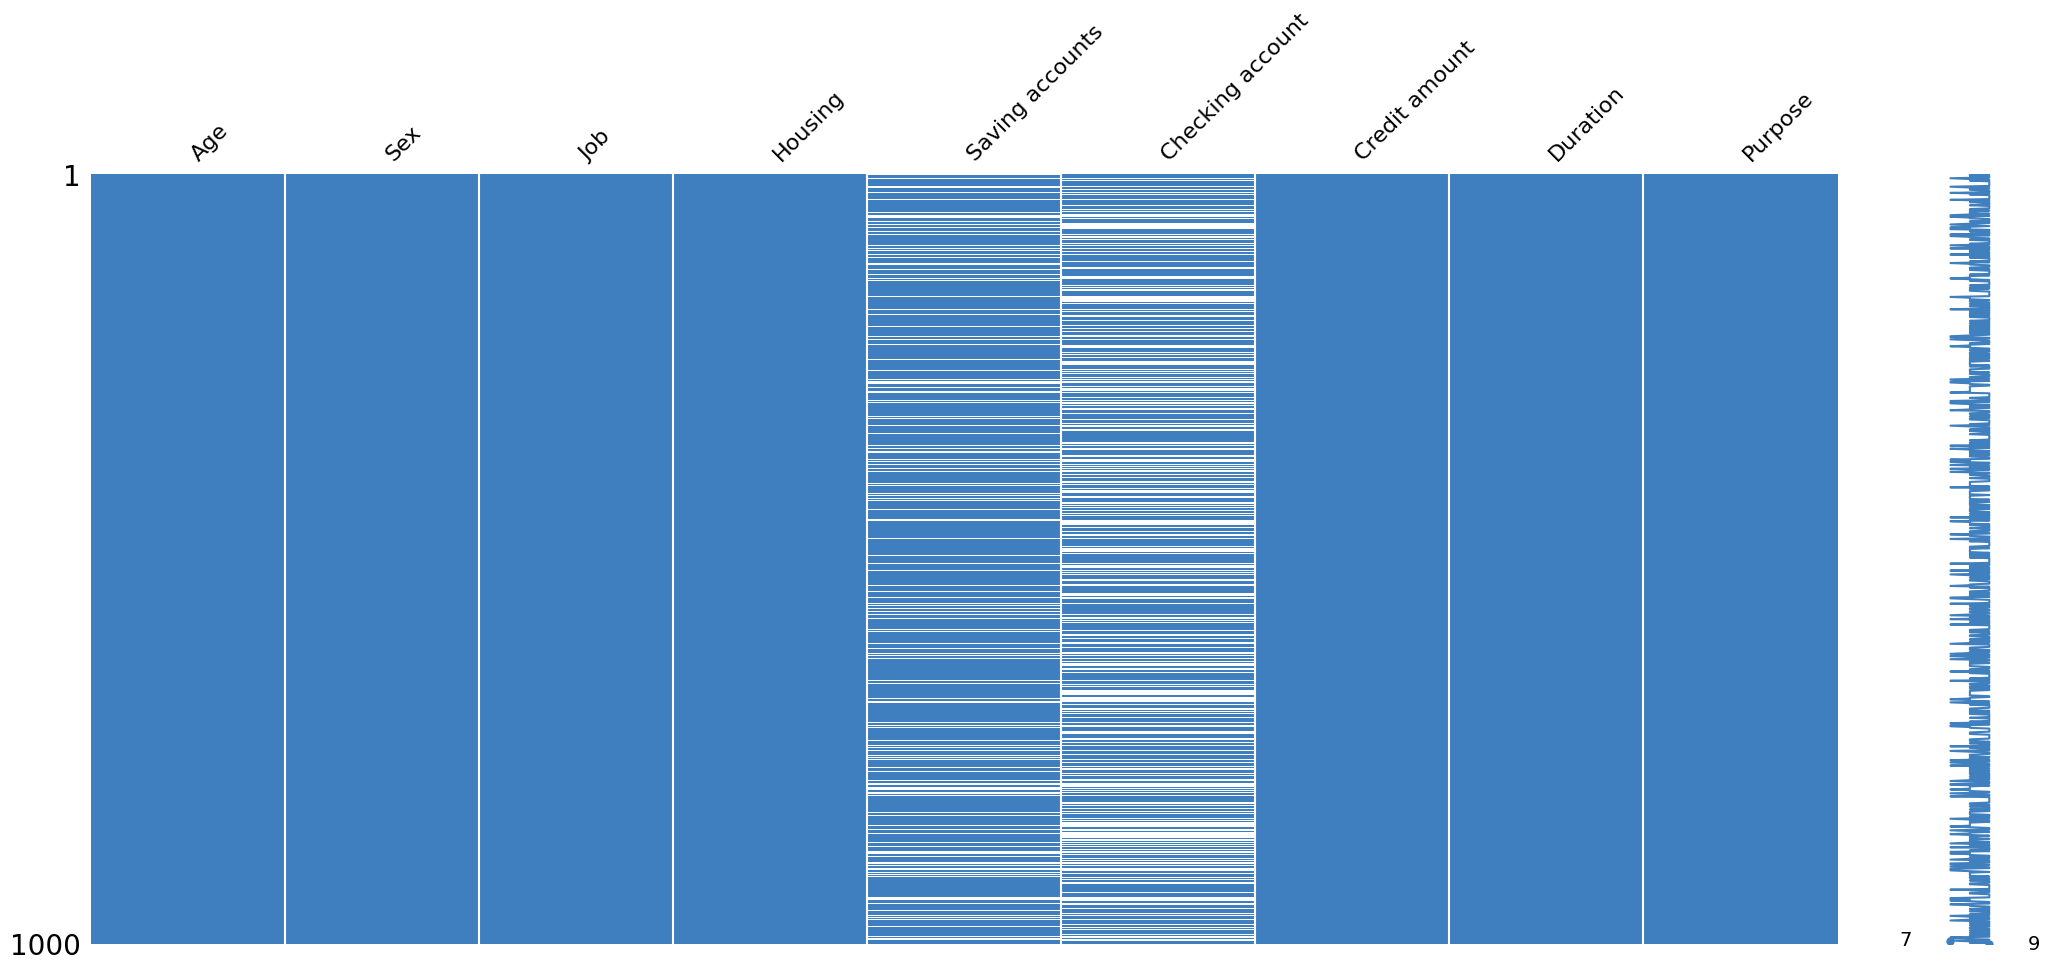

In [11]:
# Display missing values and data types
print("Missing values in each column:\n", data.isnull().sum())
print()
print("Columns data types:\n", data.dtypes)

# Visual representation of missing data
msno.matrix(data, color=(0.25, 0.5, 0.75))


Out of the 9 columns in our dataset, 2 contain missing values. These could be customers who do not have one of the accounts Savings or Checking, that is, only have one or the other but not both.

Generally, there are 4 numeric variables and 5 categorical ones.

Now, we will check how many, and what are the possible (unique) values in each categorical column.

In [12]:
# Summary statistics for numerical columns
print("Summary statistics for numerical columns")
print()
print(data.describe())

print()
# Count of unique values and their distribution in categorical columns
print("Unique values in each categorical column:")
print()
for col in data.select_dtypes(include=[object]):
    print(f"{col}:")
    print(data[col].value_counts())
    print()


Summary statistics for numerical columns

               Age          Job  Credit amount     Duration
count  1000.000000  1000.000000    1000.000000  1000.000000
mean     35.546000     1.904000    3271.258000    20.903000
std      11.375469     0.653614    2822.736876    12.058814
min      19.000000     0.000000     250.000000     4.000000
25%      27.000000     2.000000    1365.500000    12.000000
50%      33.000000     2.000000    2319.500000    18.000000
75%      42.000000     2.000000    3972.250000    24.000000
max      75.000000     3.000000   18424.000000    72.000000

Unique values in each categorical column:

Sex:
male      690
female    310
Name: Sex, dtype: int64

Housing:
own     713
rent    179
free    108
Name: Housing, dtype: int64

Saving accounts:
little        603
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64

Checking account:
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64

Purpose:
car

In [13]:
print("Data types of each categorical column:")
print()
for col in data.select_dtypes(include=[object]):
    print(col,":", data[col].unique())

Data types of each categorical column:

Sex : ['male' 'female']
Housing : ['own' 'free' 'rent']
Saving accounts : [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account : ['little' 'moderate' nan 'rich']
Purpose : ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


## Handling Missing Values

### Strategy for 'Saving accounts' and 'Checking account'

The columns 'Saving accounts' and 'Checking account' contain several missing values. We have a few strategies to handle these:

1. Imputation with a new category 'None' to indicate the absence of an account.
2. Predictive imputation (advanced and optional).
3. Removing rows/columns with missing values (not recommended due to the loss of data).

We will proceed with the first option as it adds valuable information indicating the customer does not have that type of account.

Missing values after imputation:
 Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
dtype: int64


<Axes: >

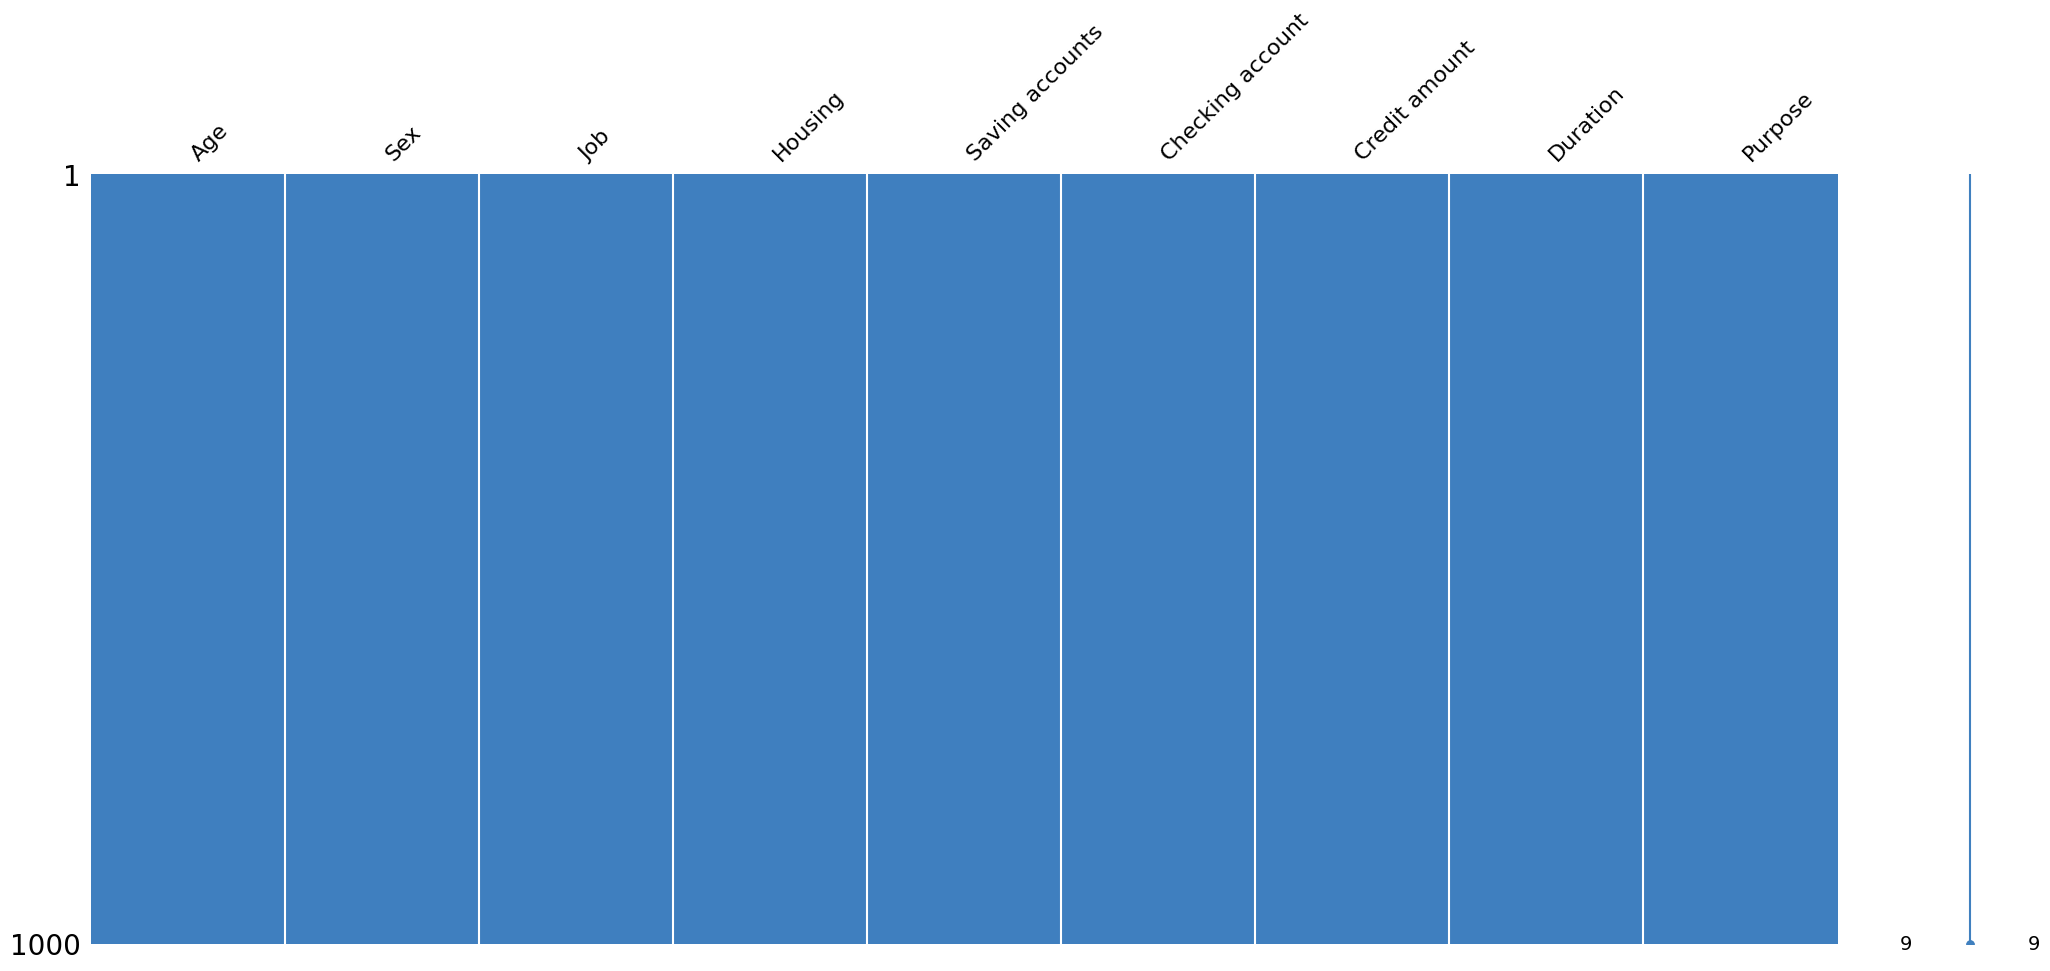

In [14]:
# Replace NaN values with 'None' to indicate the absence of an account
data['Saving accounts'].fillna('None', inplace=True)
data['Checking account'].fillna('None', inplace=True)

# Verify the changes
print("Missing values after imputation:\n", data.isnull().sum())

# Visual representation of missing data
msno.matrix(data, color=(0.25, 0.5, 0.75))


## Exploratory Data Analysis (EDA)

In this section, we will explore the relationships between different variables in our dataset, focusing on the three numerical variables: 'Credit amount', 'Duration', and 'Age'.

### Visualization Function

Below, we define a function to generate scatter plots for these numerical variables, stratified by a selected categorical column. This will help us understand how different categories (like gender) might influence these numerical factors.

In [15]:
def scatters(data, h=None, pal=None):
    # Creating scatter plots for numerical variables with optional hue parameter for categorical stratification
    fig, axes = plt.subplots(3, 1, figsize=(8, 8))
    sns.scatterplot(x="Credit amount", y="Duration", hue=h, palette=pal, data=data, ax=axes[0])
    sns.scatterplot(x="Age", y="Credit amount", hue=h, palette=pal, data=data, ax=axes[1])
    sns.scatterplot(x="Age", y="Duration", hue=h, palette=pal, data=data, ax=axes[2])
    plt.tight_layout()

At the beginning let’s look at scatter plots our 3 numerical variables stratified by sex.

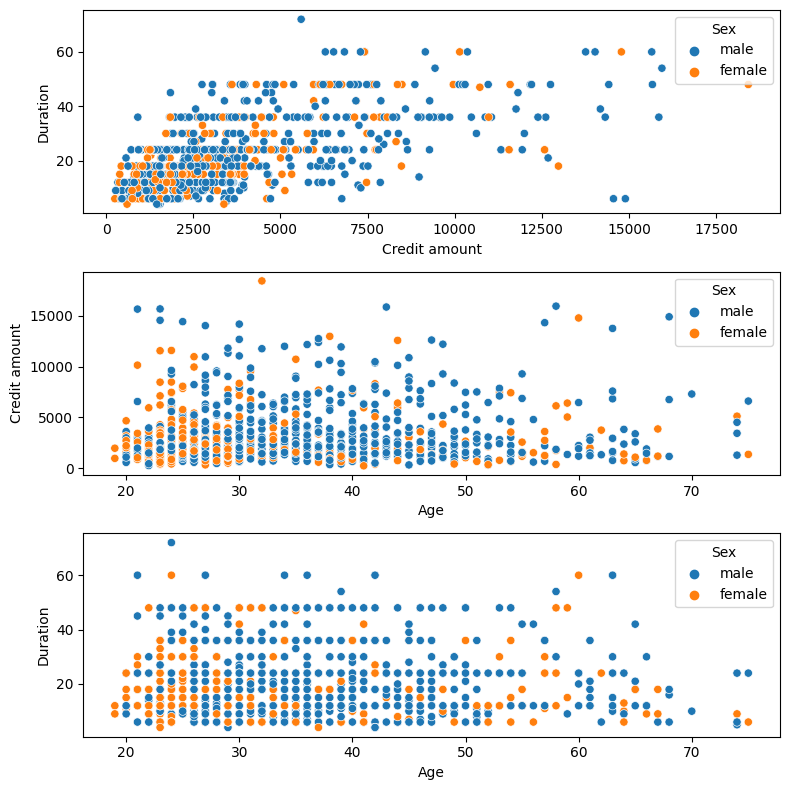

In [16]:
scatters(data, h="Sex")

##### Insights from Scatter Plots

When stratifying by 'Sex', we observe that women tend to be younger than men, however, the top plot shows that there is no clear difference between men and women in terms of amount and duration of the credit.

From visual inspection, it seems that there is some positive correlation between duration and amount of credit, which makes sense as the bigger credit,usually offered for a longer duration.

#### Correlation Analysis

Let's examine the linear correlation between 'Credit amount' and 'Duration' using a regression plot and Pearson correlation coefficient.

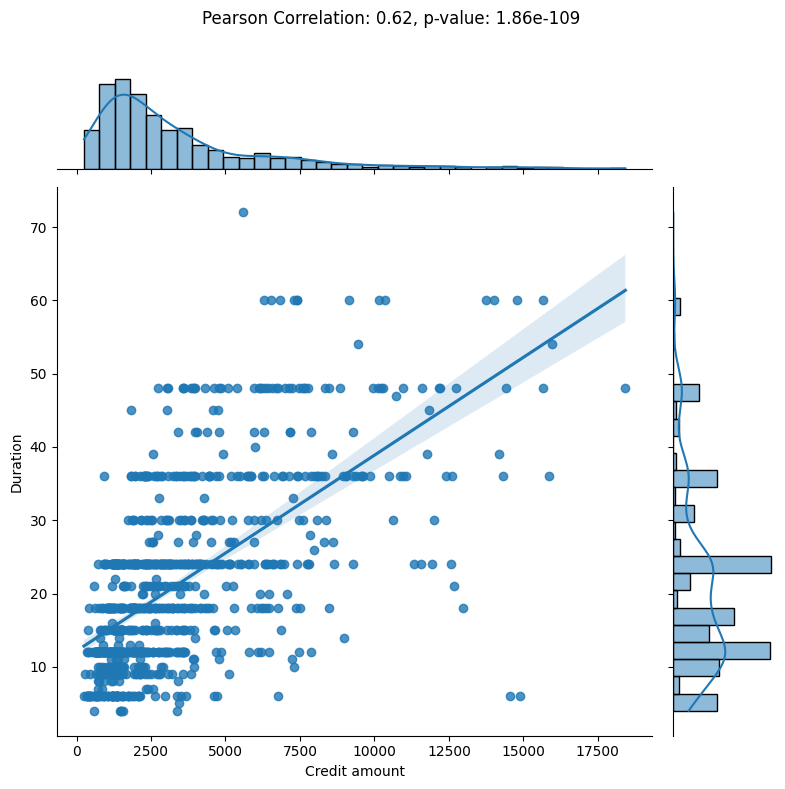

In [17]:
# Plotting the joint distribution with linear regression line
r1 = sns.jointplot(x="Credit amount", y="Duration", data=data, kind="reg", height=8)

# Calculate Pearson correlation and p-value
pearson_corr, p_value = stats.pearsonr(data["Credit amount"], data["Duration"])

# Annotate the plot with the Pearson correlation and p-value
plt.subplots_adjust(top=0.9)  # adjust the Figure in rp
r1.fig.suptitle(f'Pearson Correlation: {pearson_corr:.2f}, p-value: {p_value:.2e}')

plt.show()

The plot above shows a linear correlation with Pearson value of 0.62 and very small p-value. That make’s sense because usually, people take bigger credits for longer periods.

## Enhanced Analysis of Relationships Between Variables

In this section, we delve deeper into the relationships between various variables using advanced visualization techniques. We aim to uncover patterns and insights that might be pivotal for customer segmentation.

### Linear Regression Plots with Stratification

We start by exploring how different categories influence the relationship between 'Credit amount' and 'Duration'.

To further understand the relationships between different variables, we will create linear regression plots with various categorizations

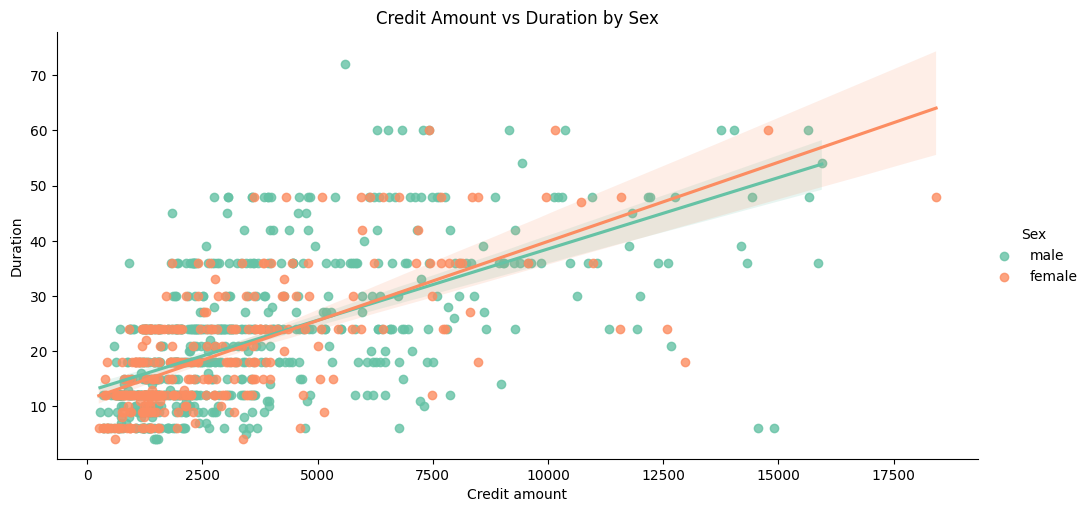

In [18]:
# Linear regression plot stratified by 'Sex'
sns.lmplot(x="Credit amount", y="Duration", hue="Sex", data=data, palette="Set2", aspect=2)
plt.title("Credit Amount vs Duration by Sex")
plt.show()

The plot above indicates that there is no significant difference between men and women.

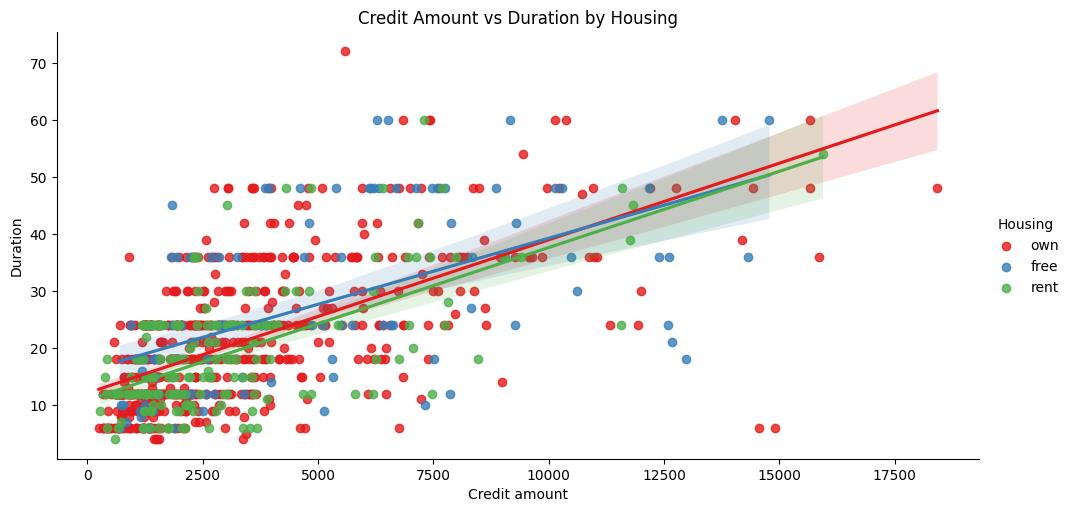

In [19]:
# Linear regression plot stratified by 'Housing'
sns.lmplot(x="Credit amount", y="Duration", hue="Housing", data=data, palette="Set1", aspect=2)
plt.title("Credit Amount vs Duration by Housing")
plt.show()

The plot above shows similarly that there is no diference betwen housing categories.


Kernel Density Estimation (KDE) Plot

Now, let's use a KDE plot to visualize the density of credits in the 'business' category.


Below I will show “business” area where granted the biggest amount of credits.

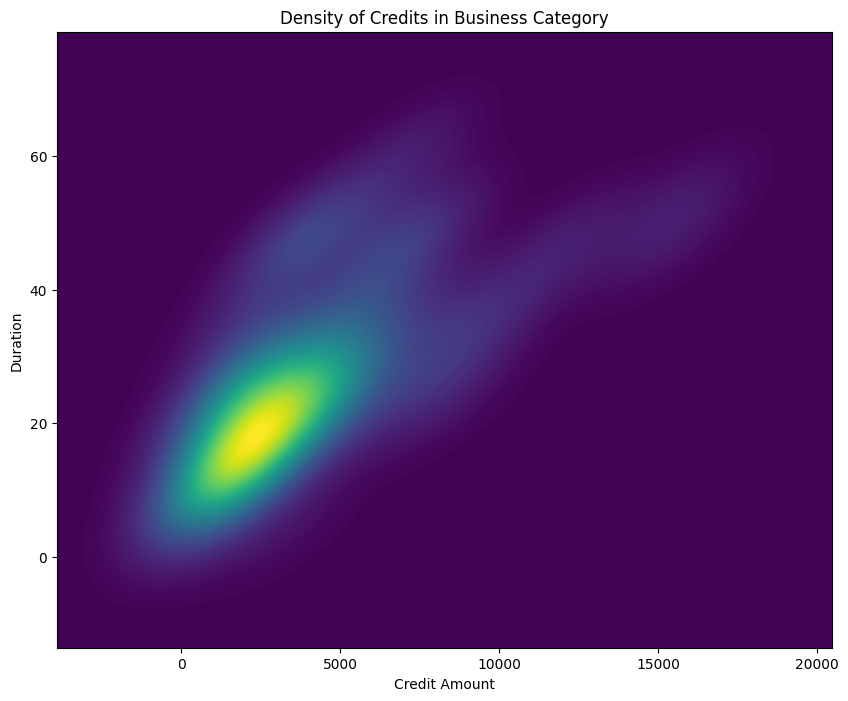

In [20]:
# KDE plot for 'business' category
# Enhanced KDE plot for the 'business' category
plt.figure(figsize=(10, 8))
kde = sns.kdeplot(
    data=data[data['Purpose'] == 'business'],
    x="Credit amount",
    y="Duration",
    fill=True, # This ensures the plot is filled with color
    cmap="viridis", # A color map that provides good contrast
    thresh=0, # Sets the lowest contour level
    levels=100 # Increases the number of contour levels for smoother gradients
)
plt.title("Density of Credits in Business Category")
plt.xlabel("Credit Amount")
plt.ylabel("Duration")
plt.show()



In our KDE plot, we see a high density of data points in the region representing medium credit amounts and durations, suggesting that this is a popular choice among our customers. The spread along the 'Credit amount' axis is wider than the 'Duration', indicating more variability in the amount of credit customers take out. The plot also shows some less common, higher credit amounts, often associated with longer durations, which could be indicative of larger purchases or investments.

#### Analyzing Credit Distribution by Purpose

We'll use an enhanced bar plot to examine how credit purposes vary in frequency.

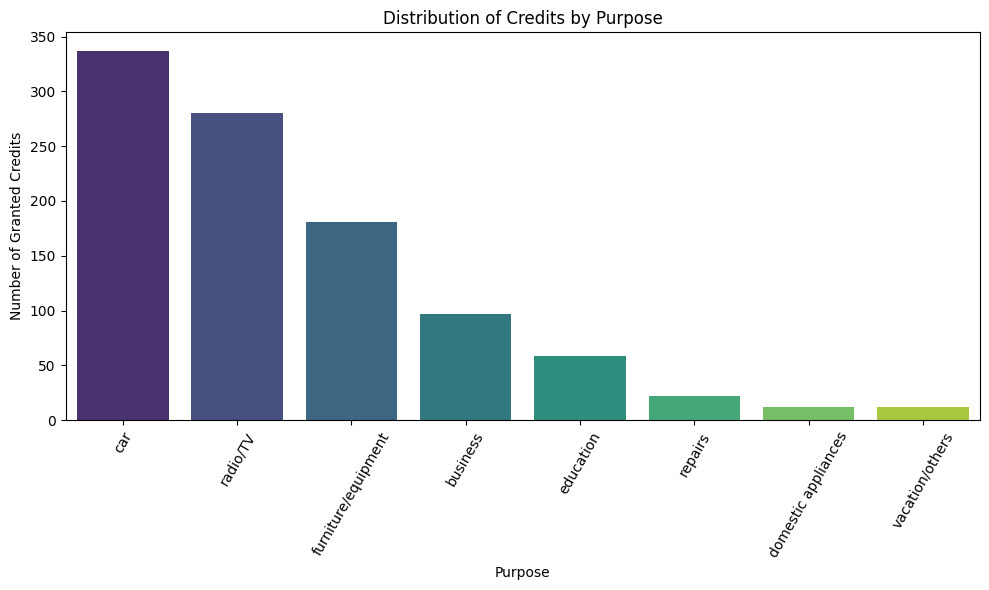

In [21]:
# Bar plot for the number of credits by purpose
n_credits = data.groupby("Purpose")["Age"].count().rename("Count").reset_index()
n_credits.sort_values(by=["Count"], ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
bar = sns.barplot(x="Purpose", y="Count", data=n_credits, palette="viridis")
bar.set_xticklabels(bar.get_xticklabels(), rotation=60)
plt.ylabel("Number of Granted Credits")
plt.title("Distribution of Credits by Purpose")
plt.tight_layout()
plt.show()


The barplot above shows how many credits were granted for various purposes. Most of credits were granted for car and radio/TV.

Detailed Boxplot Analysis

We will now generate detailed boxplots for a nuanced analysis of categorical variables.

In [22]:
def enhanced_boxes(x, y, h, r=45, palette="coolwarm"):
    fig, ax = plt.subplots(figsize=(10, 6))
    box = sns.boxplot(x=x, y=y, hue=h, data=data, palette=palette)
    box.set_xticklabels(box.get_xticklabels(), rotation=r)
    plt.title(f"{y} Distribution by {x} and {h}")
    plt.tight_layout()
    plt.show()

# Boxplots for various combinations

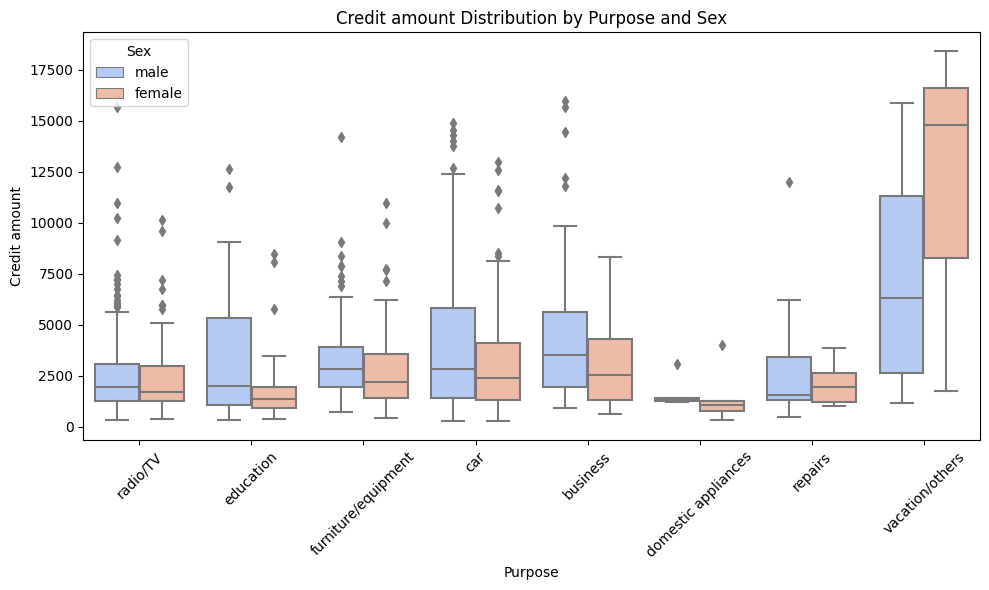

In [23]:
enhanced_boxes("Purpose", "Credit amount", "Sex")

The plot above shows that the biggest amounts are taken for vacations/others, the smallest for domestic appliances.

Most of them have outliers on the upper side of the boxes (higher amounts).

In most of the cases there is no difference between men and women, despite category vacation/others.

But one must remember that there was very little number of credits granted in this category.

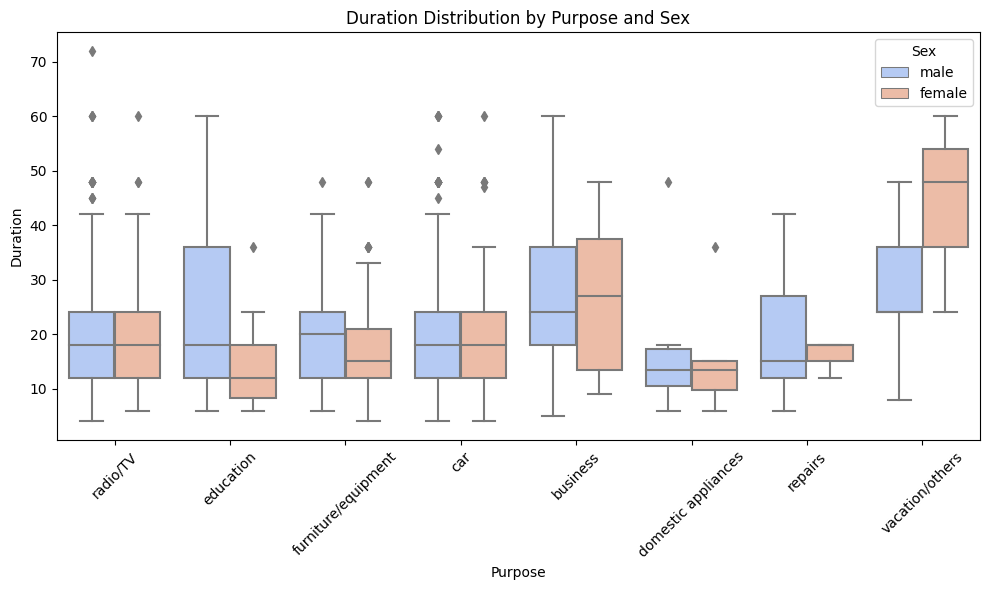

In [24]:
enhanced_boxes("Purpose", "Duration", "Sex")

The boxplot above indicates that generally there is no difference in credit duration between men and women.

We also can’t see any clear trend between categories with observations that the shortest duration is for domestic appliances.  It makes sense as it is in agreement with insights from the previous graph (credit amount) – in this category, there are the lowest amounts of credits.

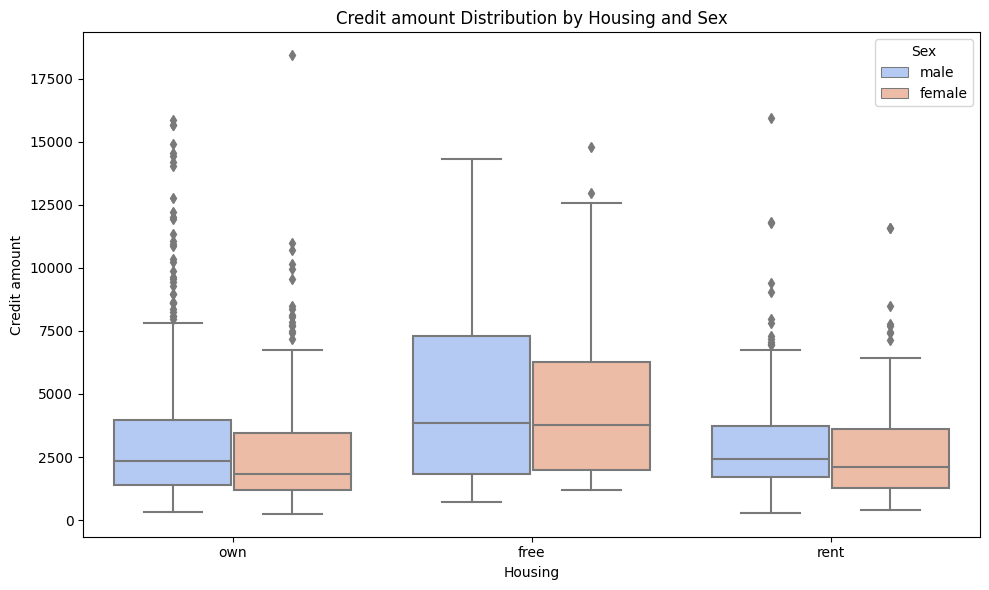

In [25]:
enhanced_boxes("Housing", "Credit amount", "Sex", r=0)

In terms of housing category, there is no big difference despite people having “free” housing tend to take slightly bigger credit amounts.

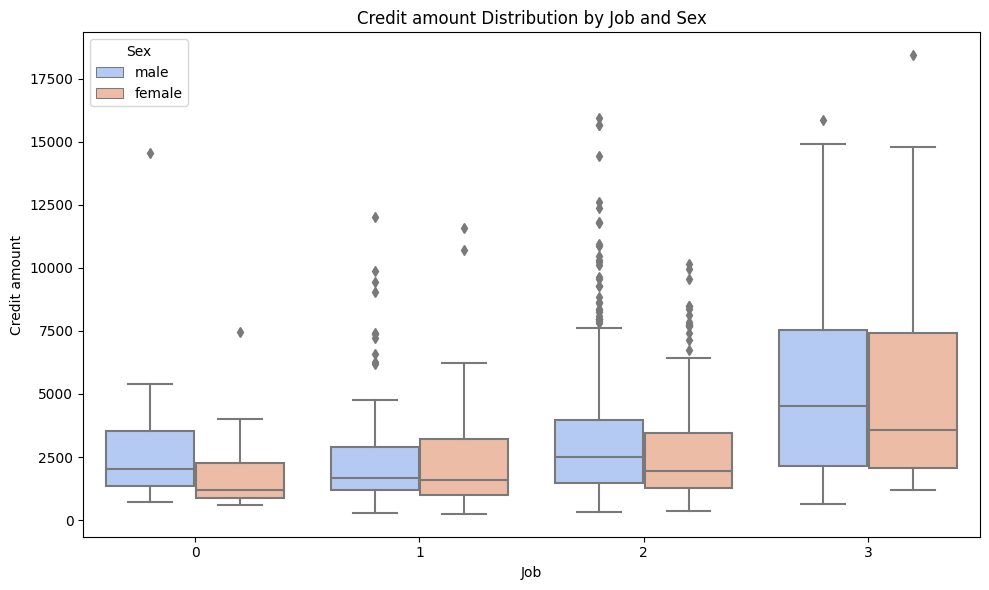

In [26]:
enhanced_boxes("Job", "Credit amount", "Sex", r=0)

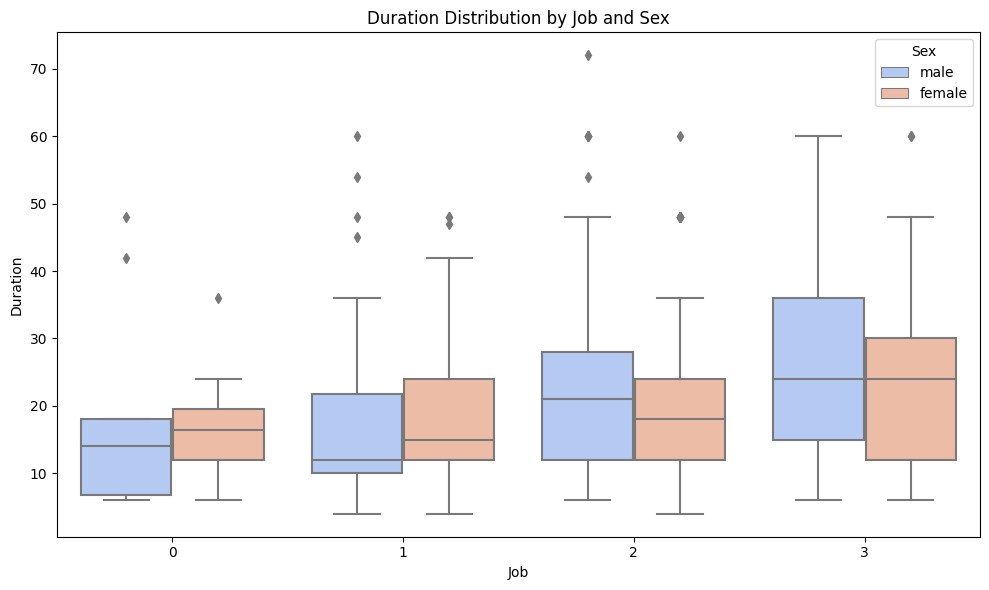

In [27]:
enhanced_boxes("Job", "Duration", "Sex", r=0)

For the above two graphs, in terms of job category once again there is no difference between men and women, but we can see that job category 3 tends to take bigger credit amounts for longer durations.  

#### 3D Visualization

Next we try a 3D scatter plot to visualize the relationship between 'Credit amount', 'Duration', and 'Age'.

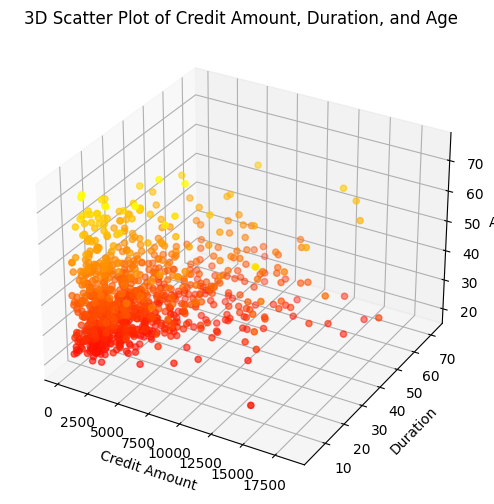

In [28]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["Credit amount"], data["Duration"], data["Age"], c=data["Age"], cmap='autumn')
ax.set_xlabel("Credit Amount")
ax.set_ylabel("Duration")
ax.set_zlabel("Age")
plt.title("3D Scatter Plot of Credit Amount, Duration, and Age")
plt.show()


The 3D scatter plot reveals several interesting patterns in our customer credit data. We observe that most of the larger credit amounts, which are spread along the X-axis, tend to be associated with longer durations, as seen along the Y-axis. Notably, there's a cluster of middle-aged customers (Z-axis) who seem to prefer these larger, longer-duration credits. However, there are outliers, such as younger individuals taking out substantial credits for shorter periods. This visualization helps us understand the multifaceted nature of our customer base and their credit behaviors.

These enhanced visualizations and analyses provide deeper insights into the relationships between various customer attributes, paving the way for more informed customer segmentation.

#**Clustering with KMeans**

In this part of the analysis, we aim to segment the bank customers using KMeans clustering, a popular unsupervised machine learning technique. We'll focus on numerical variables: 'Age', 'Credit amount', and 'Duration'.

### Data Preparation for Clustering

First, we'll prepare our data by selecting only the relevant columns for clustering.

In [29]:
# Selecting columns for clustering with KMeans
selected_cols = ["Age", "Credit amount", "Duration"]
cluster_data = data[selected_cols]

### Visualizing Distributions of Variables
Understanding the distribution of each variable is crucial before applying KMeans.

We'll create a function to plot histograms for each variable.


In [30]:
def plot_distributions(df):
    fig, axes = plt.subplots(3, 1, figsize=(8, 8))
    sns.histplot(df["Age"], kde=True, color="skyblue", ax=axes[0])
    sns.histplot(df["Credit amount"], kde=True, color="olive", ax=axes[1])
    sns.histplot(df["Duration"], kde=True, color="gold", ax=axes[2])
    plt.tight_layout()
    plt.show()

Let's look at the histograms.

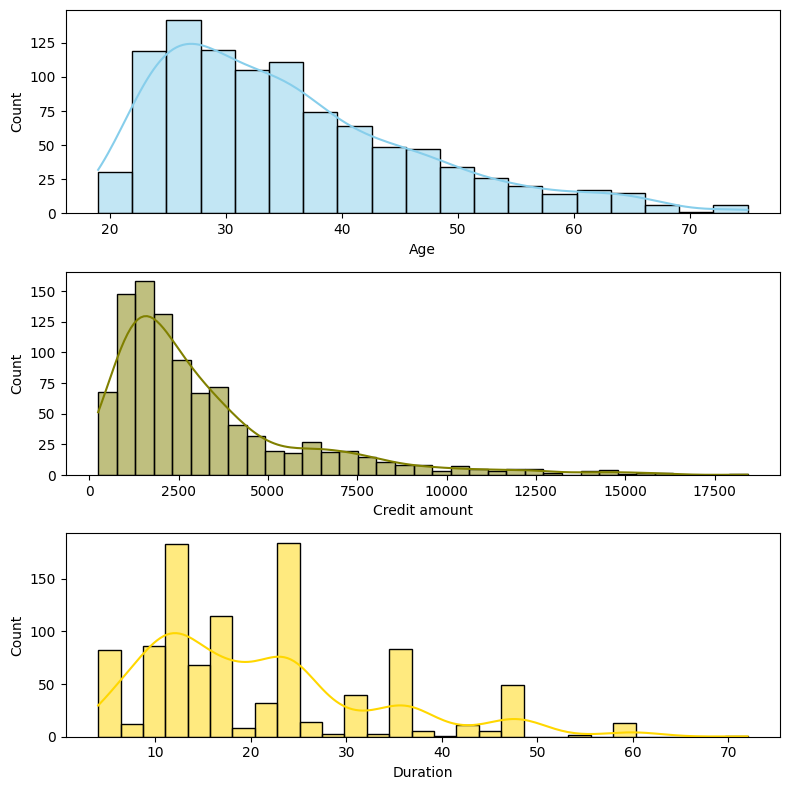

In [31]:
plot_distributions(cluster_data)

We can see that distributions are right-skewed. To obtain better results we should remove the skewness by logarithmic transformation. After that we'll see how our plots look like.

### Addressing Skewness in Data

Skewed distributions can affect the performance of KMeans. Let's apply a logarithmic transformation to reduce skewness.

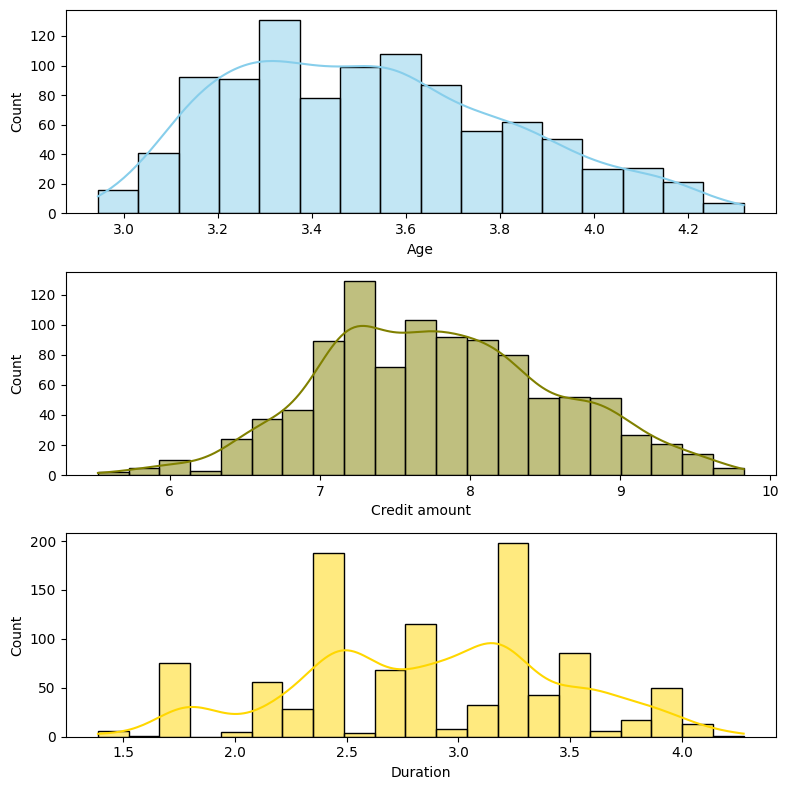

In [32]:
# Logarithmic transformation
cluster_log = np.log(cluster_data.replace(0, np.nan))
plot_distributions(cluster_log)


Indeed, the skewness has been eliminated.

### Standardization of Variables

KMeans is sensitive to the scale of the data. Therefore, we standardize our features to have a mean of 0 and a standard deviation of 1.

In [33]:
# Scaling the data
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_log.dropna())

# Convert back to DataFrame for convenience
cluster_scaled = pd.DataFrame(cluster_scaled, columns=selected_cols)


I will check how inertia changes for various number of clusters.

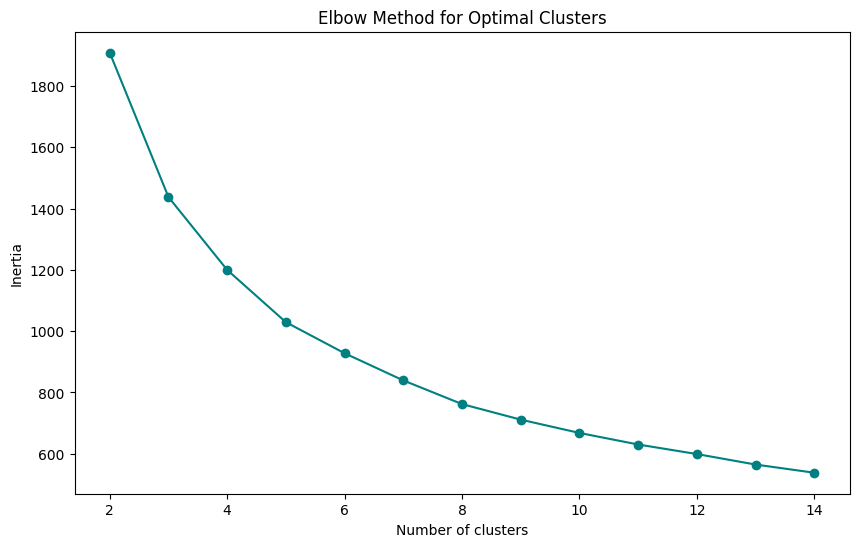

In [34]:
# Elbow method to find the optimal number of clusters
clusters_range = range(2, 15)
inertias = []

for c in clusters_range:
    kmeans = KMeans(n_clusters=c, random_state=0).fit(cluster_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(clusters_range, inertias, marker='o', color='teal')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()


The plot above shows that inertia decreases with increasing number of clusters.

### Evaluating Cluster Quality with Silhouette Scores

After observing how inertia changes with the number of clusters, we'll use silhouette scores to assess the quality of the clusters formed. This score measures how similar an object is to its own cluster compared to other clusters.

This method allows for assessment of cluster separations and fitting of each observation in its own cluster. The highest score the better. I will perform this analysis for various seeds as well.

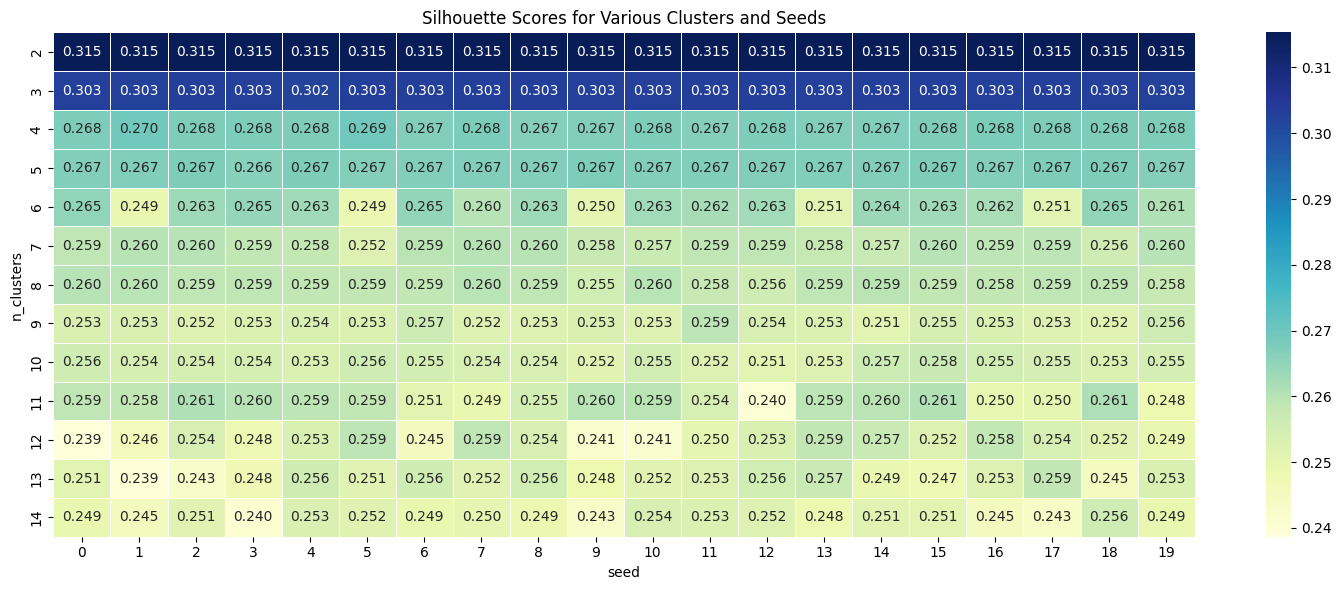

In [35]:
from sklearn.metrics import silhouette_samples, silhouette_score

# Calculating silhouette scores for different cluster numbers and seeds
results = []
for c in range(2, 15):
    for r in range(0, 20):
        clusterer = KMeans(n_clusters=c, random_state=r)
        cluster_labels = clusterer.fit_predict(cluster_scaled)
        silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
        results.append([c, r, silhouette_avg])

result_df = pd.DataFrame(results, columns=["n_clusters", "seed", "silhouette_score"])

# Creating a heatmap of silhouette scores
pivot_km = pd.pivot_table(result_df, index="n_clusters", columns="seed", values="silhouette_score")
plt.figure(figsize=(15, 6))
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap="YlGnBu")
plt.title("Silhouette Scores for Various Clusters and Seeds")
plt.tight_layout()
plt.show()

The heatmap above shows silhouette scores for various combinations of random state and number of clusters. The highest scores are for 2 and 3 clusters and they are relatively insensitive to seed.

### Selecting the Optimal Number of Clusters

Based on the silhouette scores, we choose 3 clusters for a detailed segmentation. This choice is driven by the balance between the number of clusters and the quality of clustering.

In [36]:
# Applying KMeans with the chosen number of clusters
kmeans_sel = KMeans(n_clusters=3, random_state=1).fit(cluster_scaled)
labels = pd.DataFrame(kmeans_sel.labels_)
clustered_data = cluster_data.assign(Cluster=labels)

Below I will create silhouette graph for 3 clusters in order to visually depict fit of each point within its own cluster (modified code from scikit-learn doc).

In [37]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

def silhouette_analysis(X, n_clusters):
    # Creating a subplot with 1 row and 1 column
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(10, 7)

    # Initialize the KMeans with n_clusters
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all samples
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor="black", alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()

For n_clusters = 3 The average silhouette_score is : 0.30281959056512314


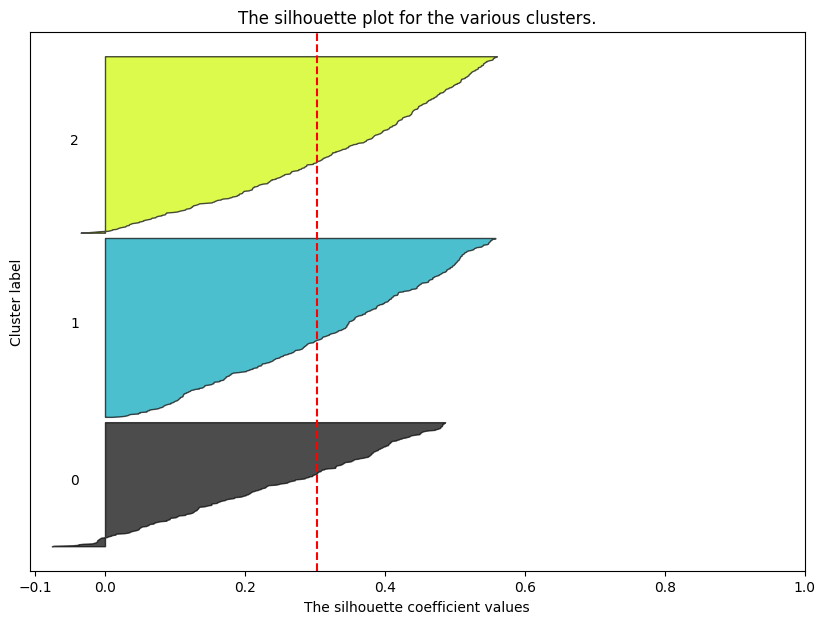

In [38]:
# Silhouette Analysis for chosen cluster number
silhouette_analysis(cluster_scaled, n_clusters=3)

###Visualization of Clusters

Next, we visualize the clusters to understand their separation and characteristics.

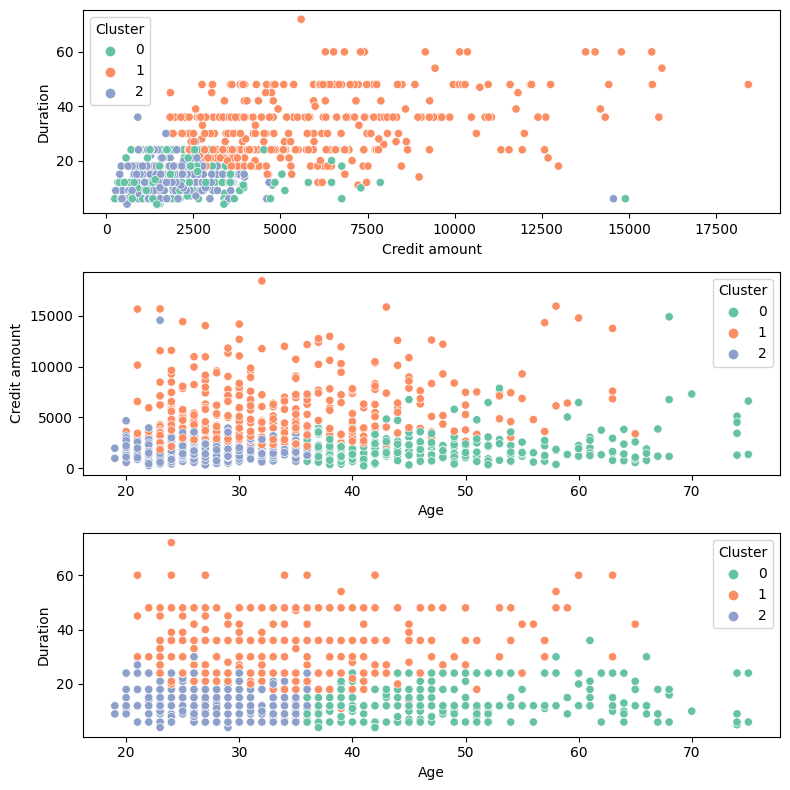

In [39]:
# Function to plot scatter plots showing clusters
scatters(clustered_data, 'Cluster', pal="Set2")


Plots above show three created clusters. Two bottom ones show relatively clear separation of clusters, but it is not so evident on the top one.

In [40]:
# Silhouette Score calculation for KMeans Clustering
kmeans_silhouette = silhouette_score(cluster_scaled, kmeans_sel.labels_)
print("KMeans Silhouette Score: ", kmeans_silhouette)


KMeans Silhouette Score:  0.30255813750380023


#### Business Interpretation of Clusters

We'll now interpret the clusters in a business context using a heatmap of the mean values for each cluster for easier business interpretation of customer segmentation.

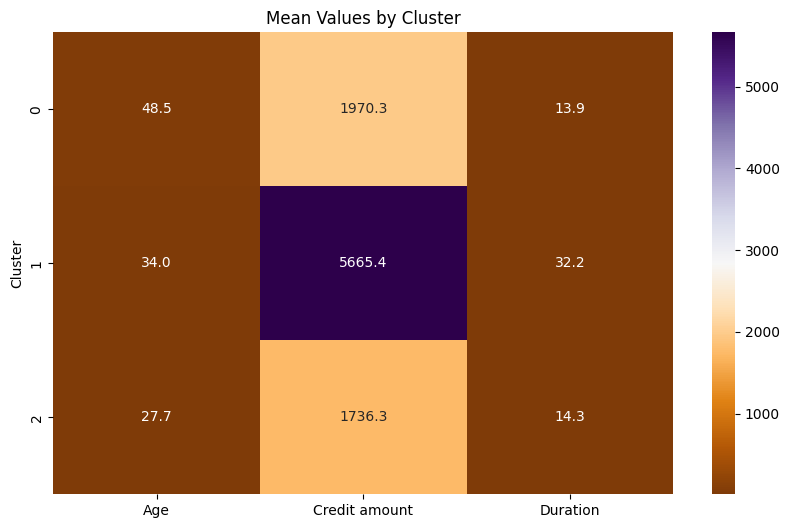

In [41]:
# Mean values by cluster for business interpretation
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)

# Heatmap of the mean values
plt.figure(figsize=(10, 6))
sns.heatmap(grouped_km, annot=True, fmt='.1f', cmap="PuOr")
plt.title("Mean Values by Cluster")
plt.show()


#### Interpretation of Clusters:

Cluster 0 –  Characterized by lowerer mean of credit amount, shorter duration, older customers.

Cluster 1 – Characterized by higher mean of credit amount, longer duration, middle-aged customers.

Cluster 2 - Characterized by lowerer mean of credit amount, shorter duration, younger customers.

#**Clustering with Affinity Propagation**

Affinity Propagation is an algorithm that does not require the number of clusters to be specified in advance. It determines the optimal number of clusters based on the data. We'll explore this method to see if it offers a unique perspective on customer segmentation.


In this algorithm there are two relevant parameters: preference and dumping. It means that we don’t define upfront number of clusters, algorithm itself chooses their number. I will fix dumping and check number of clusters in function of preference parameter.  

### Determining the Number of Clusters

We'll start by analyzing how the 'preference' parameter influences the number of clusters. This parameter acts as a message-passing parameter in the algorithm.

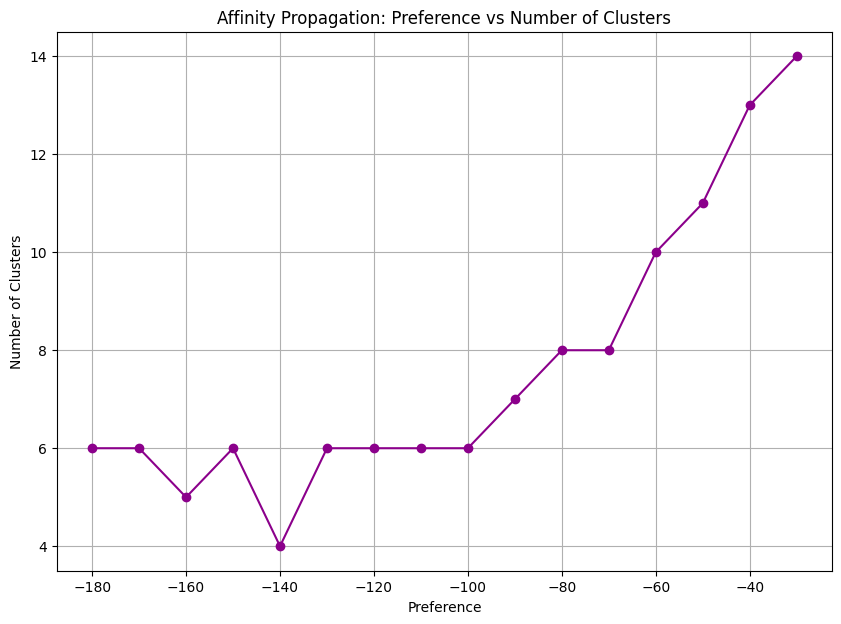

In [42]:
# Exploring the effect of the preference parameter on the number of clusters
preferences = np.arange(-30, -190, -10)
clusters = []

for p in preferences:
    af = AffinityPropagation(preference=p, damping=0.6, max_iter=400, verbose=False).fit(cluster_scaled)
    clusters.append(len(af.cluster_centers_indices_))

# Plotting the results
plt.figure(figsize=(10, 7))
plt.plot(preferences, clusters, marker='o', color='darkmagenta')
plt.xlabel("Preference")
plt.ylabel("Number of Clusters")
plt.title("Affinity Propagation: Preference vs Number of Clusters")
plt.grid(True)
plt.show()

Together with decreasing value of preference parameter number of clusters goes down as well and levels for very small preference values. I will check four clusters option.

### Analyzing the Cluster Centers

Next, we choose a preference value that results in a reasonable number of clusters. We'll examine the cluster centers to understand the characteristics of each segment.

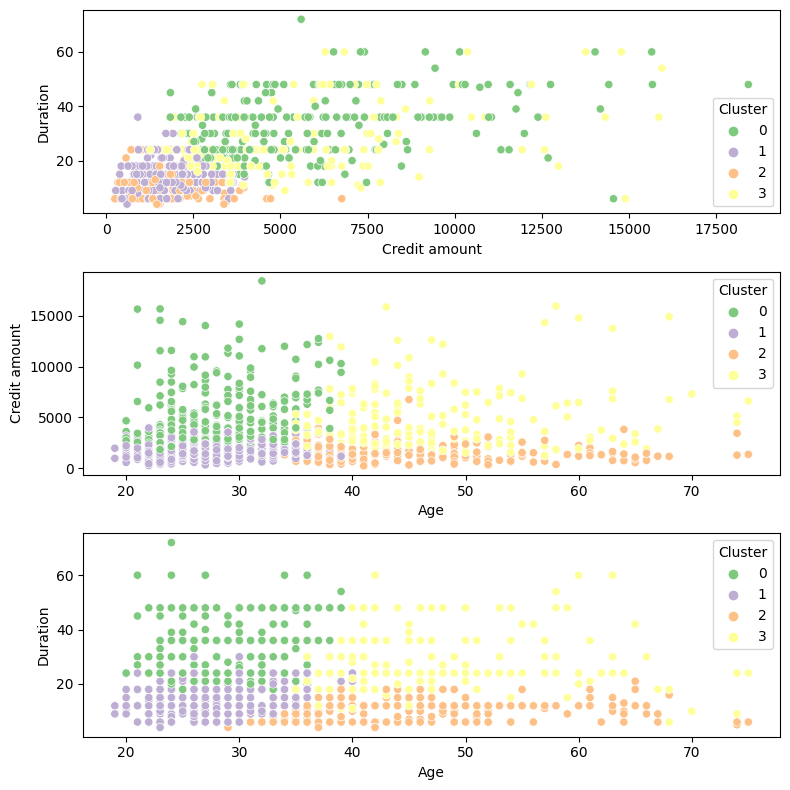

In [43]:
# Applying Affinity Propagation with the chosen preference
af_selected = AffinityPropagation(preference=-140, damping=0.6, verbose=False).fit(cluster_scaled)
labels_af = pd.DataFrame(af_selected.labels_)
n_clusters_ = len(af_selected.cluster_centers_indices_)

clustered_data_af = cluster_data.assign(Cluster=labels_af)

# Visualizing the clusters
scatters(clustered_data_af, 'Cluster', pal="Accent")

# Calculating the mean values for each cluster for business interpretation
grouped_af = clustered_data_af.groupby(['Cluster']).mean().round(1)



In [44]:
# Calculate the Silhouette Score for Affinity Propagation
af_silhouette = silhouette_score(cluster_scaled, labels_af.values.ravel())
print("Affinity Propagation Silhouette Score: ", af_silhouette)


Affinity Propagation Silhouette Score:  0.2720574101348914


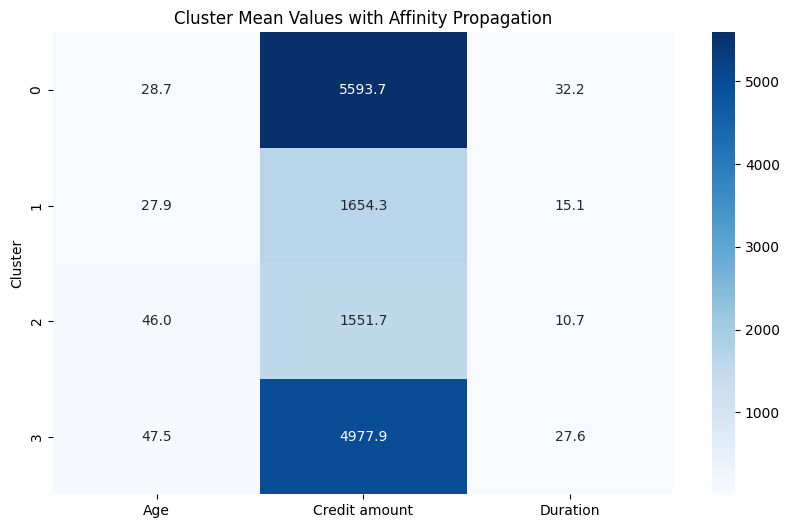

In [45]:
# Heatmap for cluster interpretation
plt.figure(figsize=(10, 6))
sns.heatmap(grouped_af, annot=True, fmt='.1f', cmap="Blues")
plt.title("Cluster Mean Values with Affinity Propagation")
plt.show()


#### Interpretation of Clusters:

Cluster 0 - Features high credit amounts and long durations, typically chosen by younger customers.

Cluster 1 - Represents low credit amounts and short durations, mostly preferred by younger customers.

Cluster 2 - Constitutes low credit amounts and short durations, commonly associated with older customers.

Cluster 3 - Includes high credit amounts with medium-term durations, often selected by older customers.

This segmentation approach with Affinity Propagation offers us an alternative perspective on our customer base, enabling us to understand diverse customer needs and preferences.

## **Exploring Hierarchical Clustering**

Hierarchical clustering is a method of cluster analysis which seeks to build a hierarchy of clusters. It can be done in two ways:

- Agglomerative: This is a bottom-up approach where each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy.
- Divisive: This is a top-down approach where all observations start in one cluster, and splits are performed recursively as one moves down the hierarchy.

In this section, we will implement Agglomerative Hierarchical Clustering to segment our bank customers. This method will help us understand the data's inherent hierarchical structure and may reveal insights different from KMeans and Affinity Propagation.


In [46]:
# Apply logarithmic transformation
# Replace zeros with a small number to avoid log(0)
cluster_log_hc = np.log(cluster_data.replace(0, 0.0001))

# Scaling the logarithmically transformed data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cluster_scaled_hc = scaler.fit_transform(cluster_log_hc)


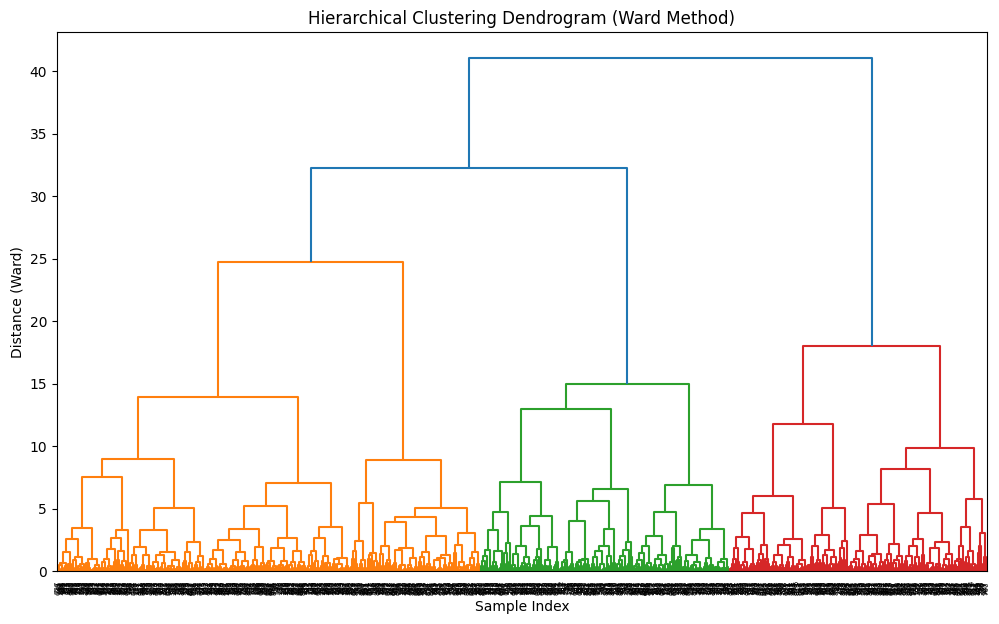

In [47]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Performing hierarchical clustering using the Ward method
linked_hc = linkage(cluster_scaled_hc, method='ward')

# Plotting the hierarchical clustering as a dendrogram
plt.figure(figsize=(12, 7))
dendrogram(linked_hc, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram (Ward Method)')
plt.xlabel('Sample Index')
plt.ylabel('Distance (Ward)')
plt.show()




#### Choosing the Number of Clusters:

The dendrogram displays how each cluster is composed by drawing a U-shaped link between a non-singleton cluster and its children. The top of the U-link indicates a cluster merge. The two legs of the U-link indicate which clusters were merged. The height of the top of the U-link represents the distance between the two clusters. A larger distance indicates less similarity. We can use this information to decide the number of clusters.

#### Applying Agglomerative Clustering:

From our dendogram analysis, we conlcuded that we have decided to have 3 clusters, we will now use AgglomerativeClustering from sklearn.cluster to form these clusters.


In [48]:
from sklearn.cluster import AgglomerativeClustering

# Applying Agglomerative Clustering
n_clusters_hc = 3  # Adjust based on dendrogram analysis
hc_model = AgglomerativeClustering(n_clusters=n_clusters_hc, affinity='euclidean', linkage='ward')
hc_labels = hc_model.fit_predict(cluster_scaled_hc)

# Add the cluster labels to your dataset
clustered_data_hc = cluster_data.assign(Cluster=hc_labels)


In [49]:
# Calculate the Silhouette Score for Hierarchical Clustering
hc_silhouette = silhouette_score(cluster_scaled_hc, hc_labels)
print("Hierarchical Clustering Silhouette Score: ", hc_silhouette)


Hierarchical Clustering Silhouette Score:  0.24114611066359173


#### Analyzing the Clusters

Similar to what we did in the KMeans and Affinity Propagation sections,we now analyze the mean values of each cluster and interpret the characteristics of each cluster.

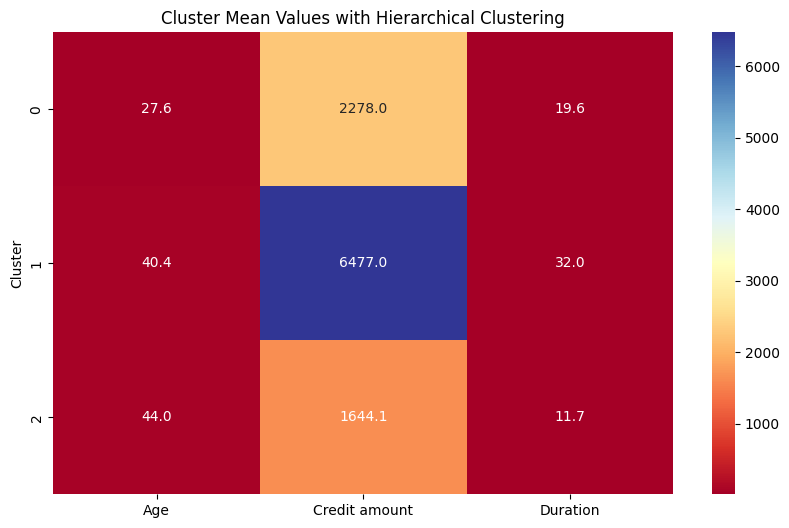

In [50]:
# Calculating the mean values for each cluster
grouped_hc = clustered_data_hc.groupby(['Cluster']).mean().round(1)

# Heatmap for cluster interpretation
plt.figure(figsize=(10, 6))
sns.heatmap(grouped_hc, annot=True, fmt='.1f', cmap="RdYlBu")
plt.title("Cluster Mean Values with Hierarchical Clustering")
plt.show()


Interpretation of Clusters:

As with the kmeans algorithm;

Cluster 0 – Characterized by lower credit amounts, shorter duration, younger customers.

Cluster 1 – Characterized by higher mean of credit amount, longer duration, middle-aged customers.

Cluster 2 - Characterized by lower mean of credit amount, shorter duration, older customers.

### **Performance Comparison of the Algorithms**

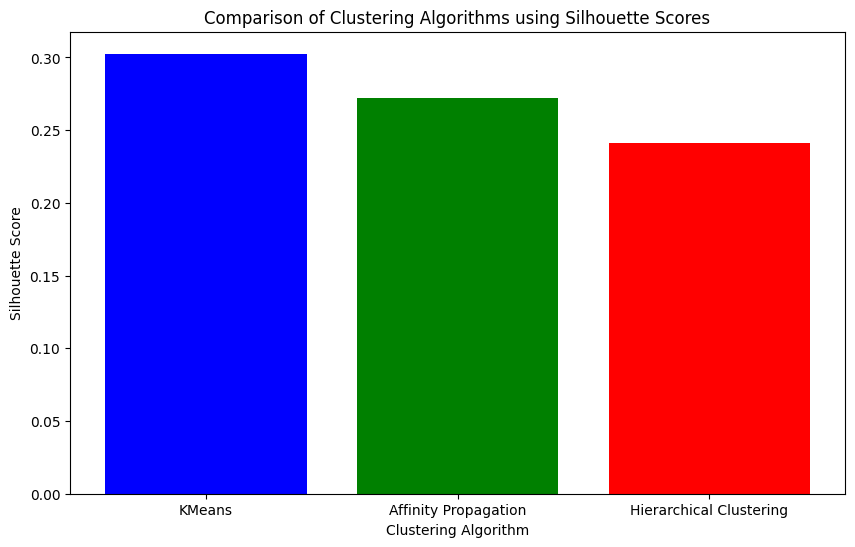

In [51]:
# silhouette scores are stored in variables:
# kmeans_silhouette, affinity_silhouette, hierarchical_silhouette

algorithms = ['KMeans', 'Affinity Propagation', 'Hierarchical Clustering']
scores = [kmeans_silhouette, af_silhouette, hc_silhouette]

plt.figure(figsize=(10, 6))
plt.bar(algorithms, scores, color=['blue', 'green', 'red'])
plt.xlabel('Clustering Algorithm')
plt.ylabel('Silhouette Score')
plt.title('Comparison of Clustering Algorithms using Silhouette Scores')
plt.show()



In conclusion, the comparison of Silhouette Scores across clustering algorithms in our study reveals KMeans as the most effective, achieving a score of 0.30. This indicates relatively good cluster separation and cohesion. Affinity Propagation follows with a score of 0.27, suggesting moderate effectiveness with slightly less distinct clusters. Hierarchical Clustering, with the lowest score of 0.24, indicates its clusters are the least distinct among the three. These results highlight KMeans as the superior method for distinct and cohesive clustering in this dataset, with the other methods providing moderate clustering quality